In [1]:
import renom as rm
from renom.cuda.cuda import set_cuda_active
import numpy as np
from sklearn.datasets import fetch_mldata
from tqdm import tqdm
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
set_cuda_active(False)

In [3]:
mnist = fetch_mldata('MNIST original', data_home='./')

In [4]:
cnn = rm.Sequential([
    rm.Conv2d(channel=32, filter=3, padding=1),
    rm.Relu(),
    rm.Conv2d(channel=64, filter=3, padding=1),
    rm.Relu(),
    rm.MaxPool2d(filter=2, stride=2),
    rm.Dropout(0.5),
    rm.Flatten(),
    rm.Dense(128),
    rm.Relu(),
    rm.Dense(10)
])

In [5]:
data = mnist['data']
targets = mnist['target']
train_num = int(0.8 * len(data))
train_data = np.expand_dims(data[:train_num].reshape(train_num, 28, 28), axis=1)
test_data = np.expand_dims(data[train_num:].reshape(len(data) - train_num, 28, 28), axis=1)
train_targets = targets[:train_num]
train_targets = LabelBinarizer().fit_transform(train_targets).astype(np.float32)
test_targets = targets[train_num:]
test_targets = LabelBinarizer().fit_transform(test_targets).astype(np.float32)

In [6]:
batch_size = 64
epochs = 1
optimizer = rm.Sgd(lr=0.001)
N = train_num
for epoch in range(epochs):
    perm = np.random.permutation(N)
    loss = 0
    test_loss = 0
    bar = tqdm(range(N//batch_size))
    for j in range(N//batch_size):
        train_batch = train_data[perm[j*batch_size:(j+1)*batch_size]]
        train_targets_batch = train_targets[perm[j*batch_size:(j+1)*batch_size]]
        with cnn.train():
            l = rm.softmax_cross_entropy(cnn(train_batch), train_targets_batch)

        l.grad().update(optimizer)
        bar.set_description("epoch {:03d} train loss:{:6.4f} ".format(epoch, float(l.as_ndarray())))
        bar.update(1)
        loss += l.as_ndarray()
    for k in range(len(test_data)//batch_size):
        test_batch = test_data[k*batch_size:(k+1)*batch_size]
        test_targets_batch = test_targets[k*batch_size:(k+1)*batch_size]
        test_l = rm.softmax_cross_entropy(cnn(test_batch), test_targets_batch)
        test_loss += test_l.as_ndarray()
    bar.set_description("epoch {:03d} avg loss:{:6.4f} val loss:{:6.4f}".format(epoch, float((loss/(j+1))), float((test_loss/(k+1)))))
    bar.update(0)
    bar.refresh()
    bar.close()

epoch 000 avg loss:0.4603 val loss:0.3767: 100%|██████████| 875/875 [27:27<00:00,  1.71s/it]


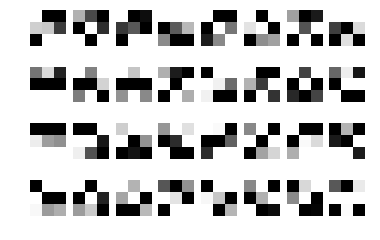

In [7]:
W = cnn._layers[0].params.w.as_ndarray()
nb_filter, nb_channel, h, w = W.shape
plt.figure()
for i in range(nb_filter):
    im = W[i, 0]
    scalar = MinMaxScaler(feature_range=(0, 255))
    im = scalar.fit_transform(im)
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(im, cmap='gray')

Original Image


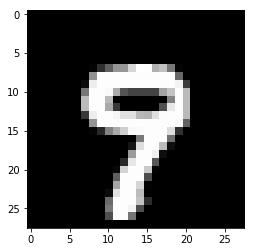

In [9]:
print('Original Image')
x = test_data[:1]
t = cnn._layers[0](x)
nb_filter, nb_channel, h, w = t.shape
plt.figure()
plt.imshow(x[0][0], cmap='gray')
plt.show()

Feature maps after the first convolutional layer


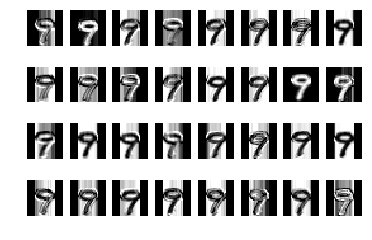

In [10]:
print('Feature maps after the first convolutional layer')
plt.figure()
for i in range(nb_channel):
    im = t[0, i, :, :]
    scalar = MinMaxScaler(feature_range=(0, 255))
    im = scalar.fit_transform(im)
    plt.subplot(4, 8, i+1)
    plt.axis('off')
    plt.imshow(im, cmap='gray')

plt.show()